# Data Science for Business - Class 2
# Time Series & Seasonality: Sales Analysis
### Name Last_Name

References:

1- Air Passenger Data for Time Series Analysis by Ashfak Yeafi: https://www.kaggle.com/datasets/ashfakyeafi/air-passenger-data-for-time-series-analysis  Uploaded under CC0 licence.





## Importing and Visualisation of Data


In [23]:
from google.colab import drive

drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import pandas as pd

train_data = pd.read_csv('/content/drive/My Drive/Class_2-Train.csv' )

In [25]:
train_data.head(n=10)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


This is a time series dataset that number of passengers "depends" on the time.

In [26]:
train_data.describe()

,Passengers
count,124.000000
mean,250.104839
std,96.309530
min,104.000000
25%,171.750000
50%,235.000000
75%,317.250000
max,505.000000


In [27]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       124 non-null    object
 1   Passengers  124 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.1+ KB


There is no missing values in the dataset.

In [28]:
train_data.isnull().sum()

Month         0
Passengers    0
dtype: int64

We use Matplotlib library to plot the data. Matplotlib is a powerful library to plot the data, when you want to have complete control over the axes (x,y) and the style of your plot. More info at https://matplotlib.org/stable/index.html .

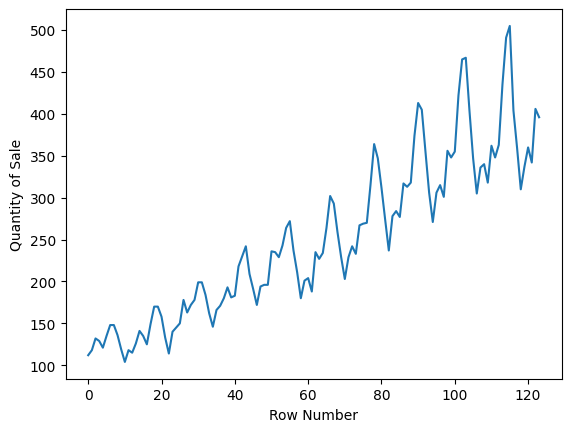

In [29]:
import matplotlib.pyplot as plt

plt.plot(train_data.Passengers)
plt.xlabel('Row Number')
plt.ylabel('Quantity of Sale')
plt.show()

We can set the x axis in Matplotlib to the date to get a more meaningful plot. We should firstly transform the Month column to date by using 'to_datetime' function of Pandas library and then give it to Matplotlib as x axis.

We can also add an optional line using gca function (get current axis) to make sure that x axis has a yearly scale.

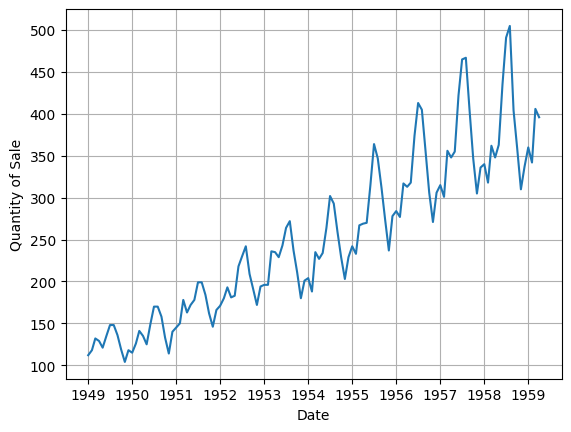

In [30]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.plot(pd.to_datetime(train_data['Month']),train_data.Passengers)
plt.xlabel('Date')
plt.ylabel('Quantity of Sale')
plt.gca().xaxis.set_major_locator(mdates.YearLocator()) #optional
plt.grid()
plt.show()

We see an increasing trend and seasonality in this time series. To find the frequency of seasonality, we have to analyse this dataset.

## Analysing seasonality in the data

Periodograms use power spectral density to find the dominant frequencies in the the data. You can find more information about them at https://en.wikipedia.org/wiki/Periodogram and https://en.wikipedia.org/wiki/Spectral_density. We use Scipy library to implement periodograms ( https://docs.scipy.org/doc//scipy/index.html ).

We make the periodogram using the relevent function in Scipy and plot it using Matplotlib. The peaks show the dominant frequencies in the dataset and the amplitude is their power. Note that to read the frequency, you should divide your selected sampling frequency by the value of x axis. For example, the second peak from left shows fs/1 = 12 (every 12 month / yearly) that is the dominant frequency of seasonality in this dataset. The third peak is fs/2 = 6 (every 6 month / semiannual). We cannot have data after fs/6 = 2 (every 2 month / bimonthly) as it is the smallest period that can be visible in a monthly dataset (more info at https://en.wikipedia.org/wiki/Nyquist_frequency).

The first peak (near zero) is because of the trend (average) of the data and should not be conisdered (fs/0 -> ∞ that shows the whole data which indicates the trend).

Changing your selected fs just changes the scale of the x axis and does not change the result.

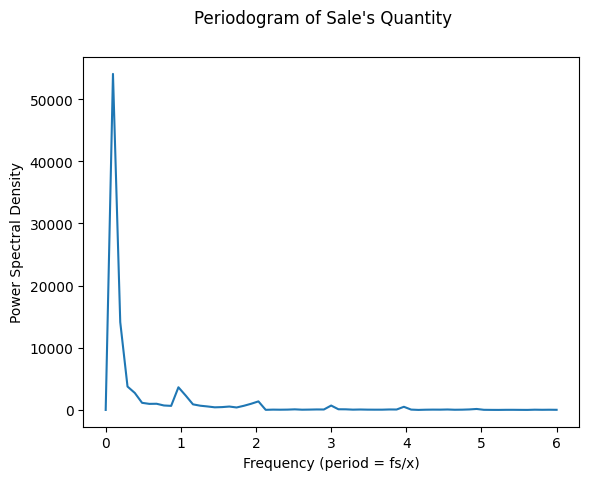

In [31]:
from scipy.signal import periodogram

freq, spectrum = periodogram(train_data.Passengers, fs=12)
plt.plot(freq,spectrum)
plt.suptitle("Periodogram of Sale's Quantity")
plt.xlabel('Frequency (period = fs/x)')
plt.ylabel('Power Spectral Density')
plt.show()

The next step is to decompose the dataset based on the dominant frequecny that we found. Additive decomposition methods use the selected period and decompose the model into three parts:

y(t) = Trend + Seasonality + Noise.

We use Statsmodel library to decompose the data. It uses smoothing averages to find the trend and after removing the trend, averaging similar values of all periods based on the selected period by the user. More information at https://online.stat.psu.edu/stat510/lesson/5/5.1 and  http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2015/tutorials/t7a_time_series.html .

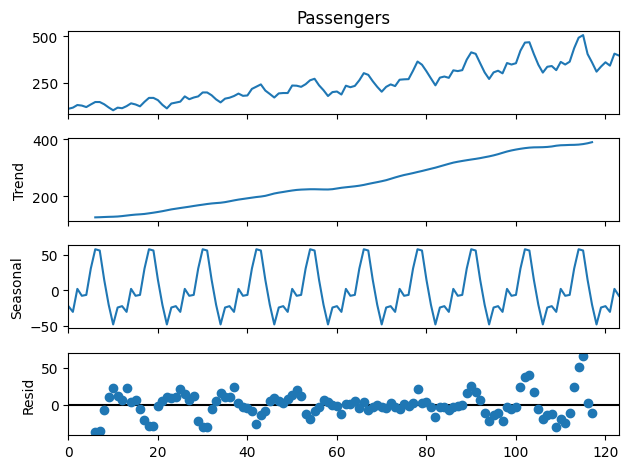

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(train_data['Passengers'], model = 'additive', period = 12)
fig = result.plot()

As we see in the figure, this model decomposes the data into trend, seasonality and noise. However, the amount of noise is not low and it has some trends in it.

## Fitting a model and prediction

After decomposing the dataset to trend and seasonality, the next step is to fit a model on our dataset to predict the future. Prophet model uses a regression method to find the trend and Fourier series to find the seasonality component.

More info at https://dev.socrata.com/blog/2019/10/07/time-series-analysis-with-jupyter-notebooks-and-socrata.html
, https://pypi.org/project/prophet/ and https://facebook.github.io/prophet/docs/quick_start.html

In [33]:
!pip install prophet

We have to prepare the data before fitting the prophet model. The time axis of the data should be named as 'ds' and the values should be named as 'y'. Additionally, it should have date-time format that can be implemented using Pandas library. When the data is prepared, we are ready to fit prophet.

In [34]:
from prophet import Prophet

model = Prophet(seasonality_mode='additive')
train_df = train_data.rename(columns={"Month":"ds","Passengers":"y"})
train_df['ds']= pd.to_datetime(train_df['ds'])
model.fit(train_df)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn40gn1pa/trq4o33p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn40gn1pa/gxdkkceg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19561', 'data', 'file=/tmp/tmpn40gn1pa/trq4o33p.json', 'init=/tmp/tmpn40gn1pa/gxdkkceg.json', 'output', 'file=/tmp/tmpn40gn1pa/prophet_modelvd2r_te6/prophet_model-20231005132242.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


To test the effectiveness of our model, we import the unseen test data. As we see in the dataset, in this example, test data shows the next months (the future).

In [35]:
test_data = pd.read_csv('/content/drive/My Drive/Class_2-Test.csv' )
test_data.head(n=10)

,Month,Passengers
0,1959-05,420
1,1959-06,472
2,1959-07,548
3,1959-08,559
4,1959-09,463
5,1959-10,407
6,1959-11,362
7,1959-12,405
8,1960-01,417
9,1960-02,391


In [36]:
test_data.describe()

,Passengers
count,20.000000
mean,467.500000
std,73.706745
min,362.000000
25%,414.500000
50%,461.000000
75%,514.750000
max,622.000000


There are 20 future samples in the test set.

We do the same data preparation on the future samples.

In [37]:
test_df = test_data.rename(columns={"Month":"ds","Passengers":"y"})
test_df['ds']= pd.to_datetime(test_df['ds'])

As we have 20 test samples to compare, we ask our prophet model to predict the number of passengers for 20 months in the future by making a monthly future data frame. By setting 'include_history' to True, the model also performs predictions on the training set (the past) that is convinient for plotting.

After finishing the data preparation, we can now predict the number of passengers for the future.

In [38]:
future = model.make_future_dataframe(20, freq='M', include_history=True)
test_predict = model.predict(future)

We use matplotlib to plot the results. We plot our prophet model predicition for the whole duration, together with the real seen values of the training set, and thereal unseen values of the test set in different colors.

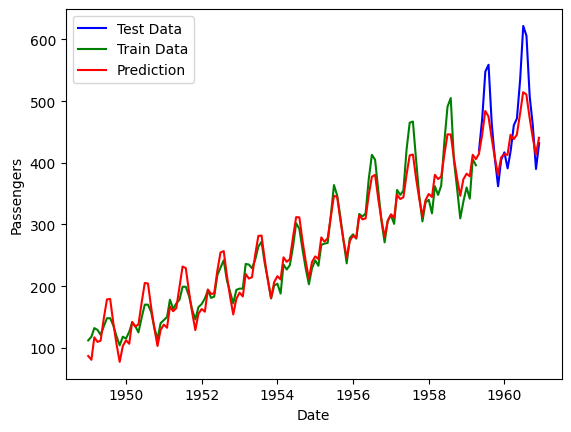

In [39]:
plt.plot(test_df.ds, test_df.y,  'b', label='Test Data')
plt.plot(train_df.ds, train_df.y,  'g' , label='Train Data')
plt.plot(test_predict.ds, test_predict.yhat,  'r', label='Prediction')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()


As we see in the results, our model works well in modeling the trend and frequency of seasonality; however, it does not work well in modeling the amplitude of seasonality.

As these errors become higher in the beginning and the end, this can be an indicator that additive decomposition does not fit well to this data, and 'multiplicative decomposition' may be a better choice.

Multiplicative decompotsition methods use the selected period and decompose the model into

y(t) = Trend * Seasonality * Noise

More information at https://online.stat.psu.edu/stat510/lesson/5/5.1 and  http://bebi103.caltech.edu.s3-website-us-east-1.amazonaws.com/2015/tutorials/t7a_time_series.html .



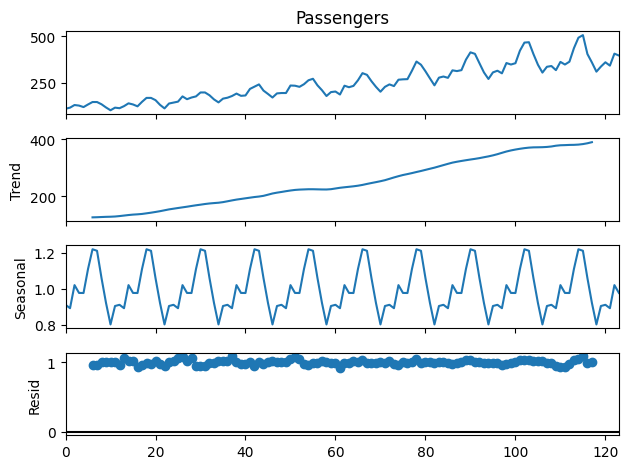

In [40]:
result = seasonal_decompose(train_data['Passengers'], model = 'multiplicative', period = 12)
fig = result.plot()

As we see in the plot, the residuals for all points are around 1, that is a good indicator in multiplicative decomposition and means that the model fits well. More importantly, there is almost no trend in the noise, as we had in additive decomposition.

We fit a prophet model with multiplicative decomposition.

In [41]:
model = Prophet(seasonality_mode='multiplicative')
model.fit(train_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn40gn1pa/hih5a0yv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpn40gn1pa/t9vyiblk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12546', 'data', 'file=/tmp/tmpn40gn1pa/hih5a0yv.json', 'init=/tmp/tmpn40gn1pa/t9vyiblk.json', 'output', 'file=/tmp/tmpn40gn1pa/prophet_model18_ltjnc/prophet_model-20231005132244.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:22:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:22:44 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [42]:
future = model.make_future_dataframe(20, freq='M', include_history=True)
test_predict = model.predict(future)

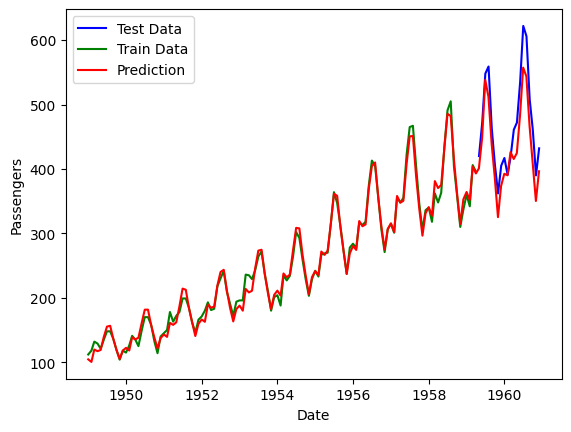

In [43]:
plt.plot(test_df.ds, test_df.y,  'b', label='Test Data')
plt.plot(train_df.ds, train_df.y,  'g' , label='Train Data')
plt.plot(test_predict.ds, test_predict.yhat,  'r', label='Prediction')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.legend()
plt.show()


As we see in the results, this time the model not only covers the trend and seasonal frequency well, but also fits well on the amplitude of seasonality.

There are more automatic and complex models available that uses machine learning approaches such as LSTM which can work better on more random datasets. You can search about them to get even better forecasting results, if you are interested!